# DIVAnd Full CARS Example

Here we illustrate reading WOD, AIMS and MNF profile data, then using DIVAnd to perform a 3d mapping

In [ ]:
using NCDatasets
using PhysOcean
using DataStructures
using DIVAnd
using Dates
using Statistics 
using Random
using Printf
#using PyPlot
using NetCDF
#using Iterators

In [ ]:
function CSIRO_standard_levels()
    
    """
    CSIRO_standard_levels()

    Simple list to return the pre-defined CSIRO standard levels

    # Examples
    ```julia-repl
    julia> CSIRO_standard_levels()
    """
    
    depth_levels  = Array{Float32}([2,5,10,20,30,40,50,60,70,75,80,90,100,110,120,125,130,140,150,160,170,175,180,190,200,
                               210,220,225,230,240,250,260,270,275,280,290,300,325,350,375,400,425,450,475,500,550,600,
                               650,700,750,800,850,900,950,1000,1100,1200,1300,1400,1500,1600,1700,1750,1800,1900,2000,
                               2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000,5500,6000])
    return depth_levels
end

In [ ]:

#==============Aus===============#

LONGITUDE_LIM_WEST = 90
LONGITUDE_LIM_EAST = 180

LATITUDE_LIM_SOUTH = -50.0
LATITUDE_LIM_NORTH =   0.0
#==============GBR===============#



dx = 0.2 # longitude resolution in degrees
dy = 0.2 # latitude resolution in degrees

lonr = Array{Float32}(LONGITUDE_LIM_WEST:dx:LONGITUDE_LIM_EAST); # the range of longitudes (start:step:end)
latr = Array{Float32}(LATITUDE_LIM_SOUTH:dy:LATITUDE_LIM_NORTH); # the range of latitudes (start:step:end)


varname = "Temperature"

platform_types = ["ctd","pfl","xbt"] #,"gld"] #,"mrb","gld","osd"]
WOD_intermediate_file_tail = ".Aus_region.interp.nc"
WOD_standard_files = []
start_year = 2005
end_year   = 2023

pressure_levels = CSIRO_standard_levels();


## Get files to import and set up domain
* Define the domain limits and horizontal and vertical grids for the mapped fields, as well as the temporal range.
* Create a list of observations to read



In [ ]:

data_path  = "/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/CODA_interp_aus_region"

#Loop through years and platform types to build a list
for i_year in start_year:end_year
    println(i_year)
    for i_platform in platform_types

        WOD_data_full_path = string(data_path,"/","WOD2018_CODA_",i_year,"_",i_platform,"_",varname,WOD_intermediate_file_tail)
        #println(WOD_data_full_path)
        if isfile(WOD_data_full_path)
            #ds = Dataset(WOD_data_full_path)
            push!(WOD_standard_files,WOD_data_full_path)
        end
    end
end

start_time_ordinate  = DateTime("1770-01-01",dateformat"y-m-d")

## Build a list of files for the ancillary data ##


In [ ]:
data_path  = "/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/CODA_interp_aus_region"
boutique_standard_files = []

data_source = ["MNF","AIMS","RAN"]
platform_type = "ctd"
#Loop through years and platform types to build a list
for i_year in start_year:end_year
    println(i_year)
    for i_source in data_source

        boutique_data_full_path = string(data_path,"/",i_source,"_CODA_",i_year,"_",platform_type,"_",varname,WOD_intermediate_file_tail)
        #println(WOD_data_full_path)
        if isfile(boutique_data_full_path)
            #ds = Dataset(WOD_data_full_path)
            push!(boutique_standard_files,boutique_data_full_path)
        end
    end
end

** Merge the data sources, which is facilitated by the CODA format **

In [ ]:
CODA_files =  [WOD_standard_files; boutique_standard_files];

In [ ]:
for i_file in 1:length(CODA_files)
    println(CODA_files[i_file])
end

## Create a list of individual World Ocean Database files to ingest. 
Here we use the vertically interpolated profiles created by the python notebook Prepare_WOD_input

In [ ]:
total_casts = 0
for file_index in 1:length(CODA_files)
    
    #Open the WOD netcdf file    
    CODA_dataset =  Dataset(CODA_files[file_index])
    
    casts = CODA_dataset["cast"]
    n_casts = length(casts)
    
    total_casts = total_casts + n_casts;
    close(CODA_dataset)
end
@show total_casts;

## Read the list of WOD files from the CODA database 

In [ ]:
#Strongly type pre-allocated arrays to avoid error
longitude   = zeros(Float32,total_casts);
latitude    = zeros(Float32,total_casts);
temperature = zeros(Float32, length(pressure_levels),total_casts);
time        = zeros(Float32,   total_casts);
dates       = Vector{DateTime}(undef, total_casts)

cast_counter = 1


for file_index in 1:length(CODA_files)
    
    #Open the WOD netcdf file    
    CODA_dataset =  Dataset(CODA_files[file_index])
    
    #Get the vertical coordinate (here pressure)
    current_depth =CODA_dataset["pressure"].var[:]
    n_profiles = length(CODA_dataset["cast"])

    
    current_longitude   =  CODA_dataset["lon"].var[:,:] 
    current_latitude    =  CODA_dataset["lat"].var[:,:] 
    current_time        =  CODA_dataset["time"].var[:]
    current_date        =  CODA_dataset["time"][:]
    current_temperature =  CODA_dataset["Temperature"].var[:,:]
    #tvec = DateTime(1770,1,1)+ Base.Dates.Day.(ncread(CODA_files[file_index],"time"))
    
    temperature[:,cast_counter:cast_counter+n_profiles-1] = current_temperature 
    longitude[cast_counter:cast_counter+n_profiles-1]   = current_longitude
    latitude[cast_counter:cast_counter+n_profiles-1]    = current_latitude
    time[cast_counter:cast_counter+n_profiles-1]        = current_time
    dates[cast_counter:cast_counter+n_profiles-1]       = current_date
    
    cast_counter = cast_counter + n_profiles
    #println(current_time)
    close(CODA_dataset)
    
end
    

observation_id = collect(Float32, UnitRange(1.0, 1.0*total_casts));

In [ ]:
@show minimum(dates)
@show maximum(dates)

In [ ]:
dates[1]

In [ ]:
scatter()

In [ ]:
for i_level in 1:length(pressure_levels)
    
    latitude_expand  =  transpose(reshape(latitude, (size(latitude)...,1)) )  ;
    longitude_expand =  transpose(reshape(longitude, (size(longitude)...,1)) ) ;
    pressure_expand  = pressure_levels[i_level] * ones(Float32,1,total_casts) ;
    variable_expand  = transpose(reshape(temperature[i_level,:], (size(temperature[i_level,:])...,1)))
    observation_id_expand =  transpose(reshape(observation_id, (size(observation_id)...,1)) ) ;
    #time_dates_expand = transpose(reshape(time_dates, (size(time_dates)...,1)) ) ;

    checkobs((longitude_expand,latitude_expand,pressure_expand,dates),
                                 variable_expand,observation_id_expand)
end # for i_level 


In [ ]:
using Plots
i_cast = 10

plot(longitude[1:11000],latitude[1:11000],seriestype=:scatter)


In [ ]:
i_cast = 2000
figure("Australian-Data")
ax = subplot(1,1,1)
#ax.plot(temperature[:,1],-depth[:,1])
ax.plot(temperature[:,i_cast],-pressure_levels[:])

In [ ]:
bathname = "/tube1/cha674/CARS_2022/cars-v2/notebooks/gebco_30sec_16.nc"
@time bx,by,b = load_bath(bathname,true,lonr,latr);

In [ ]:
aspectratio = 1
figure("Australian Bathymetry",figsize=(20,10))
ax = subplot(1,1,1)
pcolor(bx, by, permutedims(b, [2,1]));
colorbar(orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)
contour(bx, by, permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.5)
plot(longitude, latitude, "ko", markersize=.1, markerfacecolor="k")
#plot(longitude_ancillary, latitude_ancillary, "ro", markersize=.1, markerfacecolor="k")

gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)

In [ ]:
mask = falses(size(b,1),size(b,2),length(pressure_levels))
for k = 1:length(pressure_levels)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= pressure_levels[k]
        end
    end
end
@show size(mask)

In [ ]:
figure("Austrlaian Mask")
ax = subplot(1,1,1)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)
ax.pcolor(bx, by, transpose(mask[:,:,1]), cmap=PyPlot.cm.binary_r)
ax.set_title("Land-sea mask")

In [ ]:
@show size(temperature)
@show size(longitude)
@show size(dates)
@show size(latitude)

In [ ]:
i_level = 1


In [ ]:
duplicate_index = findall(.!isempty.(duplicates));
number_duplicates = length(duplicate_index);
pcdupl = round(number_duplicates / length(longitude) * 100; digits=2);
@info("Number of possible duplicates: $ndupl")
@info("Percentage of duplicates: $pcdupl%")


In [ ]:
idx_duplicates_to_remove = zeros(Int32,number_duplicates)

for i_dup in 1:number_duplicates
    idx_duplicates_to_remove[i_dup] = duplicates[i_dup][2]
end



In [ ]:
duplicates


In [ ]:
length(lonr)

## Read the BRAN derived velocity files for the advection constraint ##


In [136]:
using NetCDF
using Interpolations

u_clim = ncread("/tube1/cha674/CARS_2022_ancillary_data/BRAN_climatology/BRAN_CARS_grid_uv_AUS.monthly.clim.nc", "u");
v_clim = ncread("/tube1/cha674/CARS_2022_ancillary_data/BRAN_climatology/BRAN_CARS_grid_uv_AUS.monthly.clim.nc", "v");
model_depth =ncread("/tube1/cha674/CARS_2022_ancillary_data/BRAN_climatology/BRAN_CARS_grid_uv_AUS.monthly.clim.nc", "st_ocean");


#mean_u = mean(mean_u,dims=4);
#mean_v = mean(mean_v,dims=4);

u_clim_interp = NaN .* zeros(Float32, length(lonr),length(latr), length(pressure_levels), 12)
v_clim_interp = NaN .* zeros(Float32, length(lonr),length(latr), length(pressure_levels), 12)

current_u_profile = 0
current_v_profile = 0
for i_month in 1:12
    println(i_month)
    for i_lon in 1:length(lonr)
        for i_lat in 1:length(latr)    
            if ! all(isnan.(u_clim[i_lon,i_lat,:,i_month]))
            #println(mean_u[i_lon,i_lat,:])
            
                current_u_profile = u_clim[i_lon,i_lat,:,i_month]
                current_v_profile = v_clim[i_lon,i_lat,:,i_month]
                
                #plot(current_v_profile,pressure_levels)
                
                
                #println("hi!")
                nan_idx = findall(! isnan, current_u_profile)
                max_depth_profile = maximum(model_depth[nan_idx])
                depth_idx = findall(pressure_levels.<max_depth_profile);
     
                interp_linear = linear_interpolation( model_depth[nan_idx], current_u_profile[nan_idx],extrapolation_bc = Line() )
                u_clim_interp[i_lon,i_lat,depth_idx,i_month] = interp_linear(pressure_levels[depth_idx])
            
                interp_linear = linear_interpolation( model_depth[nan_idx], current_v_profile[nan_idx],extrapolation_bc = Line() )
                v_clim_interp[i_lon,i_lat,depth_idx,i_month] = interp_linear(pressure_levels[depth_idx])
                
                
            
            else
                #println("Missing data in slice")        
            end
        end
    end
end 

replace!(u_clim_interp, NaN=>0.0);
replace!(v_clim_interp, NaN=>0.0);

1
2
3
4
5
6
7
8
9
10
11
12


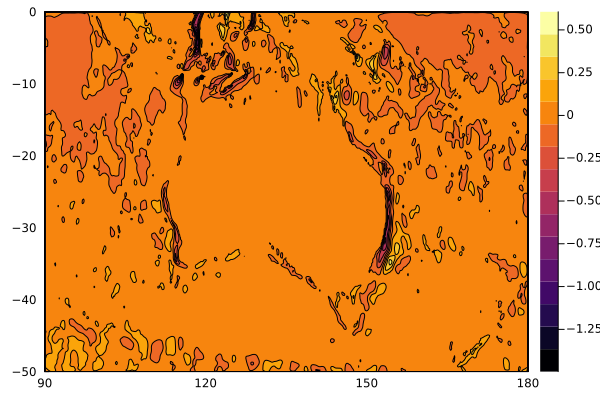

In [137]:
gr()

#contourf(lonr,latr,mean_u[:,:,1])
using Plots
#pythonplot()
v_slice = v_clim_interp[:,:,1,8]
contour(lonr,latr,transpose(v_slice),  fill = true) #levels=-1:0.1:0.5)


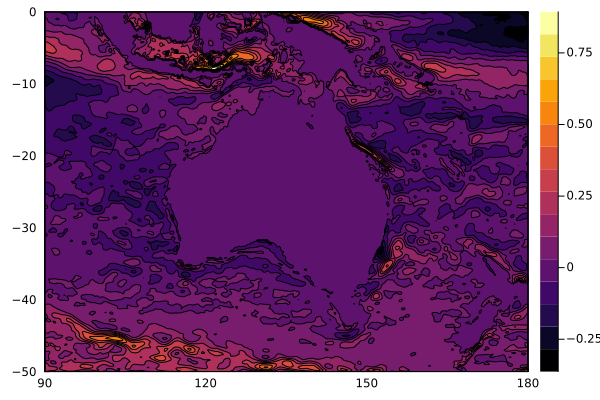

In [139]:
u_slice = u_clim_interp[:,:,1,1]
contour(lonr,latr,transpose(u_slice),  fill = true) #levels=

In [210]:
@time lenxy,infoxy = fithorzlen((longitude_level,latitude_level),convert(Array{Float64},temperature_residual),[0.0],distfun = DIVAnd.distfun_m);

  2.605074 seconds (128.42 k allocations: 20.451 MiB)


┌ Info: Data points at z=0.0: 345073, horz. correlation length: 822046.3976431402 (preliminary)
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/fit.jl:1085
┌ Info: Smoothed horz. correlation length at z=0.0: 822046.3976431402
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/fit.jl:1113


In [211]:
infoxy[:fitinfos][1]


Dict{Symbol, Any} with 8 entries:
  :sn          => 0.440193
  :rqual       => 0.97348
  :fitcovar    => [NaN, 1.28752, 1.27027, 1.24709, 1.21976, 1.18945, 1.157, 1.1…
  :meandist    => 3.89965e6
  :covar       => [1.59853, 1.44231, 1.28271, 1.20657, 1.17973, 1.15629, 1.1268…
  :range       => 4:67
  :distx       => 0.0:48745.63553386742:9.992855284442822e6
  :covarweight => [230.073, 242.049, 251.246, 256.936, 267.258, 285.514, 290.72…

In [208]:
k = 1
covar    = infoxy[:fitinfos][k][:covar]
fitcovar = infoxy[:fitinfos][k][:fitcovar]
distx    = infoxy[:fitinfos][k][:distx]
range_1    = infoxy[:fitinfos][k][:range]
rqual    = infoxy[:fitinfos][k][:rqual]



0.9358235846608787

In [212]:
lenxy

1-element Vector{Float64}:
 822046.3976431402

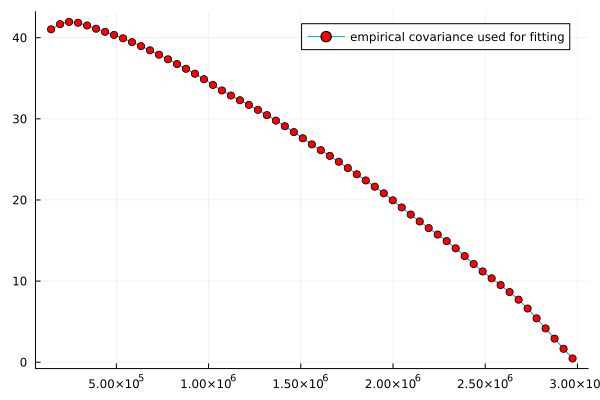

In [209]:
plot(distx,covar,label="empirical covariance")
plot(distx[range_1],covar[range_1],m=:red,label="empirical covariance used for fitting")


In [196]:
lenxy

1-element Vector{Float64}:
 11.322068258915039

In [161]:
i_level = 1

KM_TO_METERS = 1000.0
length_scale_x = 1000.0
length_scale_y = 0.5 * length_scale_x


sz = (length(lonr),length(latr)) # ,length(depthr));
lenx = fill(length_scale_x*KM_TO_METERS,sz)  # 100 km
leny = fill(length_scale_y*KM_TO_METERS,sz)   # 100 km
lenz = fill(10.,sz);      # 25 m 
len = (lenx, leny, lenz);
epsilon2 = 1.0;




using LsqFit
@. latitude_fit(x, p) = p[1] + p[2]*x + p[3]*x*x
p0 = [0.5,0.5,0.5]

temperature_level = temperature[i_level,:]
longitude_level   = copy(longitude)
latitude_level    = copy(latitude)
dates_level       = copy(dates)
time_level        = copy(time)

deleteat!(longitude_level   , findall(isnan.(temperature_level)) )
deleteat!(latitude_level    , findall(isnan.(temperature_level)) )
deleteat!(dates_level       , findall(isnan.(temperature_level)) )
deleteat!(time_level        , findall(isnan.(temperature_level)) )
deleteat!(temperature_level , findall(isnan.(temperature_level)) )

#duplicates = DIVAnd.Quadtrees.checkduplicates(
#    (longitude_level,latitude_level,time_level), temperature_level, 
#    (0.01,0.01,1/(24*60)),0.001);

#@show size(temperature_level)
#@show size(longitude_level)
#@show size(time_level)
#@show size(latitude_level)
#println("Remove Duplicates")

idx_duplicates_to_remove = zeros(Int32,0)

#duplicate_counter = 1
#for i_dup in duplicates
#    length_i_dup = length(i_dup)
#    append!( idx_duplicates_to_remove, i_dup[2:length_i_dup])
#
#    #idx_duplicates_to_remove[duplicate_counter]
    #duplicate_counter = duplicate_counter+1
#end
#idx_duplicates_to_remove = sort(idx_duplicates_to_remove)
#idx_duplicates_to_remove = unique(idx_duplicates_to_remove)

#deleteat!(longitude_level  , idx_duplicates_to_remove)
#deleteat!(latitude_level   , idx_duplicates_to_remove )
#deleteat!(time_level       , idx_duplicates_to_remove )
#deleteat!(dates_level       , idx_duplicates_to_remove )
#deleteat!(temperature_level, idx_duplicates_to_remove )

#@show size(temperature_level)
#@show size(longitude_level)
#@show size(time_level)
#@show size(latitude_level)


mean_u = mean(u_clim_interp[:,:,i_level,:],dims=3);
mean_v = mean(v_clim_interp[:,:,i_level,:],dims=3);



sel = (temperature_level .<= 35) .& (temperature_level .>= 2);
temperature_level  = temperature_level[sel];
longitude_level    = longitude_level[sel];
latitude_level     = latitude_level[sel];
time_level         = time_level[sel];
dates_level         = dates_level[sel];

#fit_temperature_to_latitude = curve_fit(latitude_fit, latitude_level, temperature_level, p0);
#temperature_residual        = fit_temperature_to_latitude.resid;


advection_factor = 5_000_000.0
xi,yi,mask = load_mask(bathname,true,lonr,latr,pressure_levels[i_level])
pm,pn = DIVAnd_metric(lonr,latr);
xi,yi = ndgrid(xi,yi)

velocity_scale = 100000.0

fi, s = DIVAndrun(  mask,(pm,pn),(xi,yi),
                       (longitude_level,latitude_level),
                        convert(Array{Float64},temperature_level),
                        (lenx,leny),epsilon2,velocity=( velocity_scale .* mean_u[:,:],
                                                        velocity_scale .* mean_v[:,:]) ); #
    
    
    
temp_mapped_BG_level =  fi #.+ latitude_fit(yi,fit_temperature_to_latitude.param);
residules_from_BG    =  DIVAnd_residualobs(s,fi);

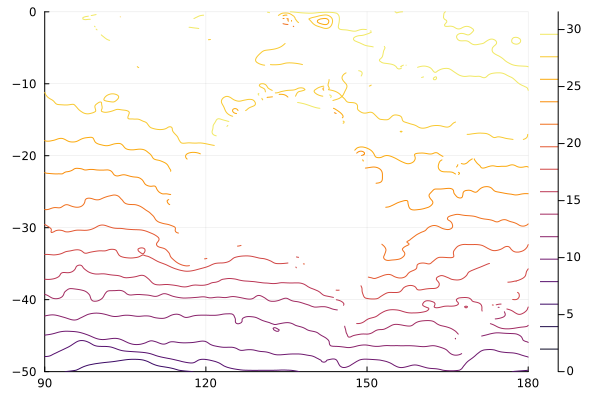

In [162]:
contour(lonr,latr,transpose(temp_mapped_BG_level),  fill = false) #levels=-1:0.1:0.5)


In [158]:
#figure(1,figsize=(20,10))
#ax = subplot(1,1,1)
#gca().set_aspect(aspectratio)

#contourf(lonr,latr,permutedims(temp_mapped_BG_level,[2,1]),
#    levels=range(6,32,step=1)) 
#colorbar()

#plot(lonr,latr,permutedims(temp_mapped_BG_level,[2,1]), st = contour)
contour(lonr,latr,transpose(temp_mapped_BG_level), st = contourf,fill = true)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
length(TS_temporal)

In [163]:
#yearlist = [[2005],[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016],[2017],[2018],[2019],[2020],[2021],[2022]]

velocity_scale = 100000.0
yearlist = [[2005,2022]]

#monthlist = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12]];
monthlist = 1:12;

TS_temporal          = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
temp_mapped_residual = zeros(Float64, length(TS_temporal), length(lonr),length(latr))

length_scale_x = 250.0
length_scale_y = length_scale_x

sz = (length(lonr),length(latr)) # ,length(depthr));
lenx = fill(length_scale_x*KM_TO_METERS,sz)  # 100 km
leny = fill(length_scale_y*KM_TO_METERS,sz)

for i_time_period in 1:length(TS_temporal)
    println("Time period: ", i_time_period)
    sel = DIVAnd.select(TS_temporal,i_time_period,dates_level)
    
    
    residules_time_slice  = residules_from_BG[sel]
    longitude_time_slice  = longitude_level[sel]
    latitude_time_slice   = latitude_level[sel]
    time_date_slice       = dates_level[sel]
    
    println()
    println("number of data:" , length(residules_time_slice))
    
    
    u_for_time_period = u_clim_interp[:,:,i_level,i_time_period];
    v_for_time_period = v_clim_interp[:,:,i_level,i_time_period];
    
    if length(residules_time_slice) !=0
        
        advection_factor = 5_000_000.0
        fi_residule, s_residule = DIVAndrun(  mask,(pm,pn),(xi,yi),
                       (longitude_time_slice,latitude_time_slice),
                        residules_time_slice,
                        (lenx,leny),epsilon2, velocity=( velocity_scale .* u_for_time_period,
                                                         velocity_scale .* v_for_time_period) ); #
        
        temp_mapped_residual[i_time_period,:,:] = fi_residule
    end

end

Time period: 1

number of data:27886


┌ Warning: Observations equal to NaN: 9
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/DIVAnd_obs.jl:45


Time period: 2

number of data:28718


┌ Warning: Observations equal to NaN: 14
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/DIVAnd_obs.jl:45


Time period: 3

number of data:27613


┌ Warning: Observations equal to NaN: 8
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/DIVAnd_obs.jl:45


Time period: 4

number of data:27439


┌ Warning: Observations equal to NaN: 9
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/DIVAnd_obs.jl:45


Time period: 5

number of data:29867


┌ Warning: Observations equal to NaN: 2
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/DIVAnd_obs.jl:45


Time period: 6

number of data:26378


┌ Warning: Observations equal to NaN: 1
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/DIVAnd_obs.jl:45


Time period: 7

number of data:30134


┌ Warning: Observations equal to NaN: 6
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/DIVAnd_obs.jl:45


Time period: 8

number of data:30430


┌ Warning: Observations equal to NaN: 6
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/DIVAnd_obs.jl:45


Time period: 9

number of data:27826


┌ Warning: Observations equal to NaN: 9
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/DIVAnd_obs.jl:45


Time period: 10

number of data:30668


┌ Warning: Observations equal to NaN: 3
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/DIVAnd_obs.jl:45


Time period: 11

number of data:30063


┌ Warning: Observations equal to NaN: 1
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/DIVAnd_obs.jl:45


Time period: 12

number of data:28024


┌ Warning: Observations equal to NaN: 2
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/DIVAnd_obs.jl:45


In [ ]:
size(temp_mapped)

In [164]:
temp_mapped = zeros(Float32, 12,length(lonr),length(latr));
for i_month in 1:12
    temp_mapped[i_month,:,:] = temp_mapped_residual[i_month,:,:] + temp_mapped_BG_level
end
temp_mapped = permutedims(temp_mapped,[2,3,1]);
temp_mapped_residual =  permutedims(temp_mapped_residual,[2,3,1]);

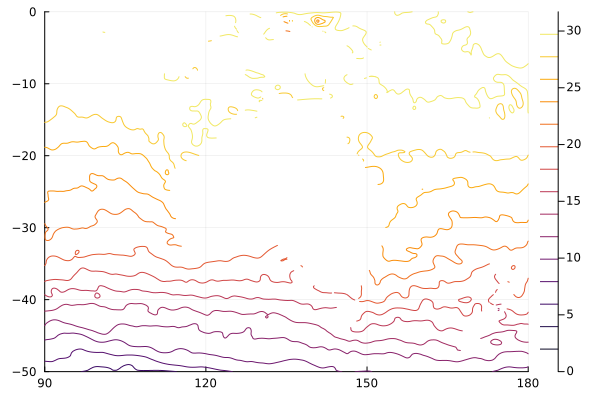

In [167]:
contour(lonr,latr,transpose(temp_mapped[:,:,1]),  fill = false) #levels=-1:0.1:0.5)

In [ ]:
u_for_time_period = u_clim_interp[:,:,i_level,1];

plot(1:length(lonr),1:length(latr),transpose(u_clim_interp[:,:,i_level,1]), st = contourf,fill = true)

In [ ]:
size(u_for_time_period)

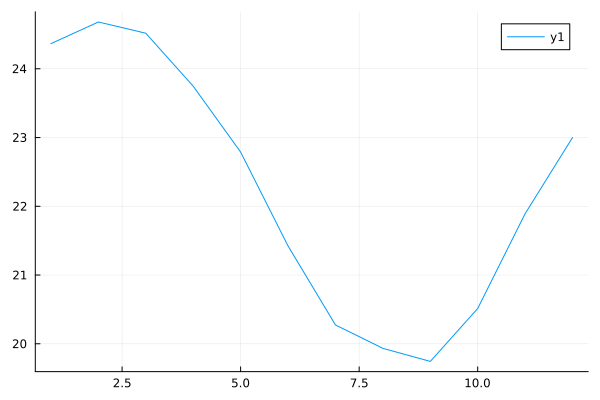

In [168]:
plot(1:12,temp_mapped[350,100,:])
plot(1:12,temp_mapped[350,100,:]) #"r*")



In [ ]:

temp_mapped = zeros(Float32, 12,length(lonr),length(latr));
i_month = 1
for i_time in 1:length(TS_temporal)

    temp_mapped[i_month,:,:] = temp_mapped_residual[i_time,:,:] .+ temp_mapped[i_month,:,:] .+ temp_mapped_BG_level;
    i_month = i_month + 1;
    
    if i_month>12
        i_month=1;
    end
end

temp_mapped = temp_mapped./length(yearlist);
replace!(temp_mapped, Inf=>-999);
replace!(temp_mapped, NaN=>-999);

temp_mapped = permutedims(temp_mapped,[2,3,1]);

In [ ]:
size(temp_mapped)

In [ ]:
using NetCDF
output_file_path = "/oa-decadal-climate/work/observations/CARSv2_ancillary/CARS_2022_mapped/CASRS_2022_test_CODA.nc"


varatts = Dict("longname" => "Ocean Temperature",
          "units"    => "degree Celsius")
lonatts = Dict("longname" => "Longitude",
          "units"    => "degrees east")
latatts = Dict("longname" => "Latitude",
          "units"    => "degrees north")
timatts = Dict("longname" => "Month",
          "units"    => "Month of year");

nccreate(output_file_path,"temperature","lon",lonr,lonatts,"lat",latr,latatts,"month",collect(1:12),timatts,atts=varatts);

ncwrite(temp_mapped,output_file_path,"temperature");
ncclose(output_file_path)



In [ ]:

defDim(output_dataset,"longitude",lonr)
defDim(output_dataset,"latitude",latr)
defDim(output_dataset,"month",collect(1:12))
output_dataset.attrib["title"] = "Test CARS2022 output"


temperature_output = defVar(output_dataset,"temperature",Float32,("month","longitude","latitude"), 
                            attrib = OrderedDict("units" => "degree Celsius",)  )
temperature_output[:,:,:] = temp_mapped;

temperature_output.close()



In [ ]:
contourf(lonr,latr,permutedims(temp_mapped[:,:,1],[2,1]),
    levels=range(2,30,step=1),cmap="magma",extend="both") 
colorbar()

In [ ]:
figure(1,figsize=(20,10))
ax = subplot(1,1,1)
gca().set_aspect(aspectratio)

contourf(lonr,latr,permutedims(temp_mapped_residual[200,:,:],[2,1]),
    levels=range(-5,5,step=1),cmap="magma",extend="both") 
colorbar()

In [ ]:
contourf(permutedims(temp_mapped[7,:,:],[2,1]),
    levels=range(6,32,step=1),cmap="magma",extend="both") 
colorbar()

In [ ]:
plt.plot(temp_mapped[:,600,300])
plt.plot(temp_mapped[:,700,200])

In [ ]:
checkobs((longitude_ancillary,latitude_ancillary,depth_ancillary,time_dates_ancillary),temperature,observation_id_ancillary)


In [ ]:
fi, s = DIVAndrun(mask,(pm,pn),(xi,yi),(longitude,latitude),temperature_residual,(lenx,leny),epsilon) #, moddim=md)